<a href="https://colab.research.google.com/github/arnaldog12/Machine_Learning/blob/master/Adaboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

|  |  |
|-------------|-------|
| 🎓 **Aprendizado** | Supervisionado |
| 📋 **Tarefa** | Classificação |
| 🔧 **Normalização** | Sim |
| ⭐ **Dificuldade** | Média |

# ⚙️ 0. Dependências

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 🔍 1. Introdução

**Boosting** é uma abordadem de Machine Learning baseada na ideia de criar regras de predição com alta acurácia pela combinação de regras fracas e imprecisas. Boosting também é uma das abordages de aprendizagem supervisionada mais populares e bem sucedidas.

O **Adaboost** é a técnica mais popular de boosting. A ideia básica do algoritmo é, para cada iteração, treinar um classificador fraco (accurácia > 50%) dando preferência (maiores pesos) aos exemplos incorretamente classificados pelo classificador anterior. Ao final, um classificador forte é construído pelo voto ponderado de cada um dos classificadores.

✅ **Vantagens:**
- Fácil implementação
- Rápido
- Apenas um parâmetro para tunning (número de estimadores)
- Pode ser usado como seletor de características
- Boa generalização
- Versátil

❌ **Desvantagens:**
- Não é robusto a presença de ruído uniforme
- Muitos classificadores fracos podem acarretar em overfitting


**Pseudo-algoritmo**

1. Para cada um dos n_estimadores:
    - treine um classificador binário $C_i$ com $y \in \{-1, +1\}$ de acordo com os pesos $w$
    - Calcula as predições do classificador
    - Calcule a taxa de erro ponderada
    
    $$
    e = w * 1(y \neq y_{pred}) = 1 - w * 1(y=y_{pred}) \tag{1}
    $$
    
    - Calcule os coeficientes
    
    $$\alpha_i = 0.5 * \log{\frac{1-e}{e}} \tag{2}$$
    
    - Atualize os pesos
    
    $$
    w = w * \exp^{-\alpha_i * y * y_{pred}} \tag{3}
    $$
    
    - Normalize os pesos
    
    $$w = \frac{w}{\sum w} \tag{4}$$

O Classificador final será dado por:

$$sign(\sum_i{\alpha_i*C_i.predict(x_{test})}) \tag{5}$$

# 🎲 2. Dados

Os dados são baseados na [aula sobre boosting](https://www.youtube.com/watch?v=u1MXf5N3wYU) do [curso de Machine Learning da Udacity](https://br.udacity.com/course/machine-learning--ud262). Eu tentei reproduzir, o mais fielmente possível, os dados do gráfico mostrado na aula.

(0.0, 10.0)

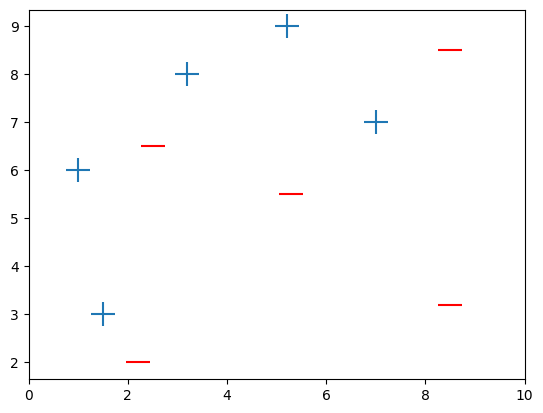

In [ ]:
x = np.array([[1.0, 6.0],[1.5, 3.0],[3.2, 8.0],[5.2, 9.0],[7.0, 7.0],
              [2.2, 2.0],[2.5, 6.5],[5.3, 5.5],[8.5, 8.5],[8.5, 3.2]])
y = np.array([1, 1, 1, 1, 1, -1, -1, -1, -1, -1])

plt.scatter(x[:5,0], x[:5,1], s=300, marker='+')
plt.scatter(x[5:,0], x[5:,1], s=300, marker='_', color='red')
plt.xlim(0, 10)

# 💻 3. Implementação

In [ ]:
def weighted_accuracy(pred, y, weights):
    return sum([w for p,t,w in zip(pred, y, weights) if p==t])/sum(weights)

def sign(x):
    if x == 0: return 0
    return 1 if x > 0 else -1

Como o Adaboost pode utilizar qualquer classificador como base, nós vamos implementar um classificador que só traça linhas em cada atributo (*feature*) tentando maximizar a acurácia.

In [ ]:
class LineClassifier():
    def __init__(self, weights=np.array([])):
        self.weights = weights
        self.value, self.col = 0, 0

    def fit(self, x, y):
        column_count = len(x[0])

        if len(self.weights) == 0:
            self.weights = [1.0/len(x)]*len(x)

        best_accuracy = 0.0

        for col in range(column_count):
            column_values = [row[col] for row in x]

            for value in np.arange(min(column_values), max(column_values), 0.1):
                accuracy = weighted_accuracy(LineClassifier.predict_(x, col, value), y, self.weights)

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    self.col, self.value = col, value

    def predict(self, x):
        return LineClassifier.predict_(x, self.col, self.value)

    @staticmethod
    def predict_(x, col, value):
        if col == 0:
            return [1 if row[col] < value else -1 for row in x]
        else:
            return [1 if row[col] > value else -1 for row in x]

In [ ]:
class AdaBoost():
    def __init__(self, base_estimator=LineClassifier, minHitRate=0.5, n_estimators=50):
        self.classifiers = []
        self.alphas = []
        self.weights = []
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.minHitRate = minHitRate

    def fit(self, x, y):
        from math import log, e
        ln = lambda x: log(x)/log(e)

        if len(self.weights) == 0:
            self.weights = np.ones(len(x)) / len(x)

        for n in range(self.n_estimators):
            clf = self.base_estimator()
            clf.weights = self.weights
            clf.fit(x, y)

            pred = clf.predict(x)
            error = 1.0 - weighted_accuracy(pred, y, self.weights) # Eq. (1)

            if(error < self.minHitRate):
                alpha = 0.5 * ln((1-error) / error) # Eq. (2)

                self.weights = [w * (e ** (-alpha * p *t)) for p,t,w in zip(pred, y, self.weights)] # Eq. (3)
                self.weights = [w / sum(self.weights) for w in self.weights] # Eq. (4)

                self.classifiers.append(clf)
                self.alphas.append(alpha)

                print('[{}]: ε={:.2f} α={:.2f}'.format(n, error, alpha))

    def predict(self, x):
        predictions = []

        for row in x:
            weak_sum = 0.0

            for alpha, clf in zip(self.alphas, self.classifiers):
                weak_sum += alpha*clf.predict([row])[0]
            predictions.append(np.sign(weak_sum)) # Eq. (5)

        return np.array(predictions)

### Comparação com o Scikit-Learn

A gente pode conferir a implementação por esse [link](https://alliance.seas.upenn.edu/~cis520/wiki/index.php?n=lectures.boosting).

In [ ]:
ada = AdaBoost(base_estimator=LineClassifier, n_estimators=3, minHitRate=0.3)
ada.fit(x, y)
y_pred = ada.predict(x)

print('y_true:', y)
print('y_pred:', y_pred)

[0]: ε=0.30 α=0.42
[1]: ε=0.21 α=0.65
[2]: ε=0.14 α=0.92
y_true: [ 1  1  1  1  1 -1 -1 -1 -1 -1]
y_pred: [ 1.  1.  1.  1.  1. -1. -1. -1. -1. -1.]


(0.0, 10.0)

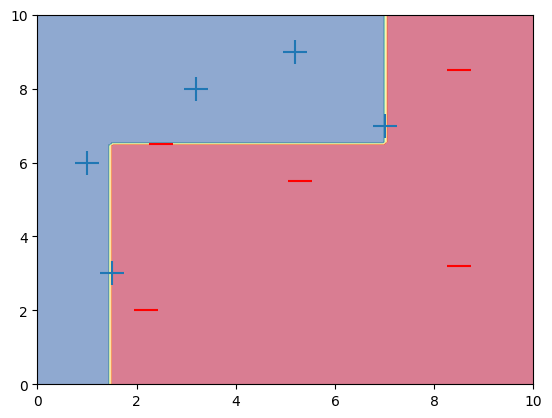

In [ ]:
xv, yv = np.meshgrid(np.linspace(0, 10, 100), np.linspace(0, 10, 100))
xyv = np.concatenate((xv, yv), axis=1)

pred_2 = []
for i in range(xv.shape[0]):
    for j in range(xv.shape[1]):
        pred_2.append(ada.predict([[xv[i,j], yv[i,j]]]))

pred_2 = np.array(pred_2).reshape(xv.shape)
plt.contourf(xv, yv, pred_2, cmap=plt.cm.Spectral, alpha=0.6)
plt.scatter(x[:5,0], x[:5,1], s=300, marker='+')
plt.scatter(x[5:,0], x[5:,1], s=300, marker='_', color='red')
plt.xlim(0,10)
plt.ylim(0,10)

# 📖 Referências

- [Machine Learning by Georgia Tech (Udacity)](https://br.udacity.com/course/machine-learning--ud262)
- [Playlist about Adaboost on Youtube (same as above)](https://www.youtube.com/watch?v=w75WyRjRpAg)
- [CIS 520 - Machine Learning 2018](https://alliance.seas.upenn.edu/~cis520/wiki/index.php?n=lectures.boosting)